In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nftoniotv2/NetFlow v2 Features.csv
/kaggle/input/nftoniotv2/NF-ToN-IoT-V2.parquet


In [2]:
from os import cpu_count
from math import floor
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [3]:
data=pd.read_parquet("/kaggle/input/nftoniotv2/NF-ToN-IoT-V2.parquet")

## very very Basic EDA

In [4]:
data.dtypes

L4_SRC_PORT                      int32
L4_DST_PORT                      int32
PROTOCOL                          int8
L7_PROTO                       float32
IN_BYTES                         int32
IN_PKTS                          int32
OUT_BYTES                        int32
OUT_PKTS                         int32
TCP_FLAGS                        int16
CLIENT_TCP_FLAGS                 int16
SERVER_TCP_FLAGS                 int16
FLOW_DURATION_MILLISECONDS       int32
DURATION_IN                      int32
DURATION_OUT                     int32
MIN_TTL                          int16
MAX_TTL                          int16
LONGEST_FLOW_PKT                 int32
SHORTEST_FLOW_PKT                int16
MIN_IP_PKT_LEN                   int16
MAX_IP_PKT_LEN                   int32
SRC_TO_DST_SECOND_BYTES        float64
DST_TO_SRC_SECOND_BYTES        float64
RETRANSMITTED_IN_BYTES           int32
RETRANSMITTED_IN_PKTS            int16
RETRANSMITTED_OUT_BYTES          int32
RETRANSMITTED_OUT_PKTS   

In [5]:
data.Label.value_counts()

1    9534597
0    3601284
Name: Label, dtype: int64

In [6]:
data.Attack.value_counts()

Benign        3601284
scanning      3002169
xss           2449955
ddos          1746590
password       993718
injection      660467
dos            654359
backdoor        16259
mitm             7723
ransomware       3357
Name: Attack, dtype: int64

In [7]:
data=data.drop(columns=['L4_SRC_PORT', 'L4_DST_PORT']) #dropping metadata

## Finding contaminant features using XAI (SHAP)
goal: 
- try to find the contaminant features that have blanked predictive power across all attack classes

method:
* look for shap values per feature that are consistantly high or low among all attack classes.
   
how:
```
possible_contaminants =[]
    while models can achive high accuracy{
    
        * Train a binary classification model (e.g., xgboost) on different attack classes and benign class
        * For each model, calculate shappley values on test set
        * For each model, use np.abs(shap_values).mean(0) to compute the mean absolute SHAP value for each feature across all samples. 
          This will give you a measure of how much each feature contributes to the model output on average across all samples (the importance).
          
        * normalize importances across for each attack class sum of feature importances equals 1
        * for each feature, calculate variance of importance for each attack class
        * for each feature, calculate average importance across all attack classes
        * score of a feature is the weighted sum of the importance and variance
        
        * feature F is feature with the highest score
        * possible_contaminants.append(F)
        * drop F from dataset
    }
```

In [8]:
training_set = data.sample(frac=0.3, replace=False,random_state=42)
# 1%train, 99% test
testing_set = data.drop(index=training_set.index)

In [9]:
training_set.Attack.value_counts()

Benign        1080399
scanning       901211
xss            734104
ddos           523655
password       297668
injection      198421
dos            197104
backdoor         4842
mitm             2360
ransomware       1000
Name: Attack, dtype: int64

In [10]:
attacks=training_set.Attack.unique()
attacks=[ 'Benign','ddos', 'dos', 'scanning', 'xss', 'injection',
       'password', 'mitm', 'backdoor', 'ransomware']
attacks

['Benign',
 'ddos',
 'dos',
 'scanning',
 'xss',
 'injection',
 'password',
 'mitm',
 'backdoor',
 'ransomware']

### split into dataframes per attack class

In [11]:
grouped = training_set.groupby(training_set.Attack)
dfs={cat:grouped.get_group(cat) for cat in attacks[1:]}
dfs[attacks[0]]=grouped.get_group(attacks[0]) #don't subsample normal attacks
#dfs key=attack_cat, value is dataframe 

In [12]:
# to make calculations faster
for k,v in dfs.items():
    if v.shape[0]>10000:
        dfs[k]=v.sample(10000,replace=False)

In [13]:
for atk_type in attacks[1:]:
    normals_to_sample = dfs[atk_type].shape[0]
#     print(normals_to_sample)
    normals_sample = dfs['Benign'].sample(normals_to_sample)
#     dfs['Normal'] = dfs['Normal'].drop(index=normals_sample.index)#don't resample
    dfs[atk_type] = pd.concat(objs=[dfs[atk_type], normals_sample])
    print(dfs[atk_type].shape[0], normals_sample.shape[0], dfs['Benign'].shape[0])

20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
4720 2360 10000
9684 4842 10000
2000 1000 10000


In [14]:
testing_dfs = {}
grouped = testing_set.groupby(testing_set.Attack)
testing_dfs={cat:grouped.get_group(cat) for cat in attacks[1:]}
testing_dfs[attacks[0]]=grouped.get_group(attacks[0]) #don't subsample normal attacks
#testing_dfs key=attack_cat, value is dataframe 

In [15]:
#to make calculations faster
for k,v in testing_dfs.items():
    if v.shape[0]>10000:
        testing_dfs[k]=v.sample(10000,replace=False)

In [16]:
for atk_type in attacks[1:]:
    normals_to_sample = testing_dfs[atk_type].shape[0] 
    normals_sample = testing_dfs['Benign'].sample(normals_to_sample)
#     testing_dfs['Normal'] = testing_dfs['Normal'].drop(index=normals_sample.index)#don't resample
    testing_dfs[atk_type] = pd.concat(objs=[testing_dfs[atk_type], normals_sample])
    print(testing_dfs[atk_type].shape[0], normals_sample.shape[0], testing_dfs['Benign'].shape[0])

20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
20000 10000 10000
10726 5363 10000
20000 10000 10000
4714 2357 10000


In [17]:
print(f"TRAINING SETS")
for k,v in dfs.items():
    v.drop(columns=['Attack'], inplace=True)   
    print(k, v.shape)
    print(v['Label'].value_counts())

TRAINING SETS
ddos (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
dos (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
scanning (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
xss (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
injection (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
password (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
mitm (4720, 40)
1    2360
0    2360
Name: Label, dtype: int64
backdoor (9684, 40)
1    4842
0    4842
Name: Label, dtype: int64
ransomware (2000, 40)
1    1000
0    1000
Name: Label, dtype: int64
Benign (10000, 40)
0    10000
Name: Label, dtype: int64


In [18]:
print("TESTING SETS")
for k,v in testing_dfs.items():
    v.drop(columns=['Attack'], inplace=True)   
    print(k, v.shape)
    print(v['Label'].value_counts())

TESTING SETS
ddos (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
dos (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
scanning (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
xss (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
injection (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
password (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
mitm (10726, 40)
1    5363
0    5363
Name: Label, dtype: int64
backdoor (20000, 40)
1    10000
0    10000
Name: Label, dtype: int64
ransomware (4714, 40)
1    2357
0    2357
Name: Label, dtype: int64
Benign (10000, 40)
0    10000
Name: Label, dtype: int64


In [19]:
training_dfs=dfs

In [20]:
import plotly.express as px

### TCP_WIN_MAX_IN

In [21]:
attacks

['Benign',
 'ddos',
 'dos',
 'scanning',
 'xss',
 'injection',
 'password',
 'mitm',
 'backdoor',
 'ransomware']

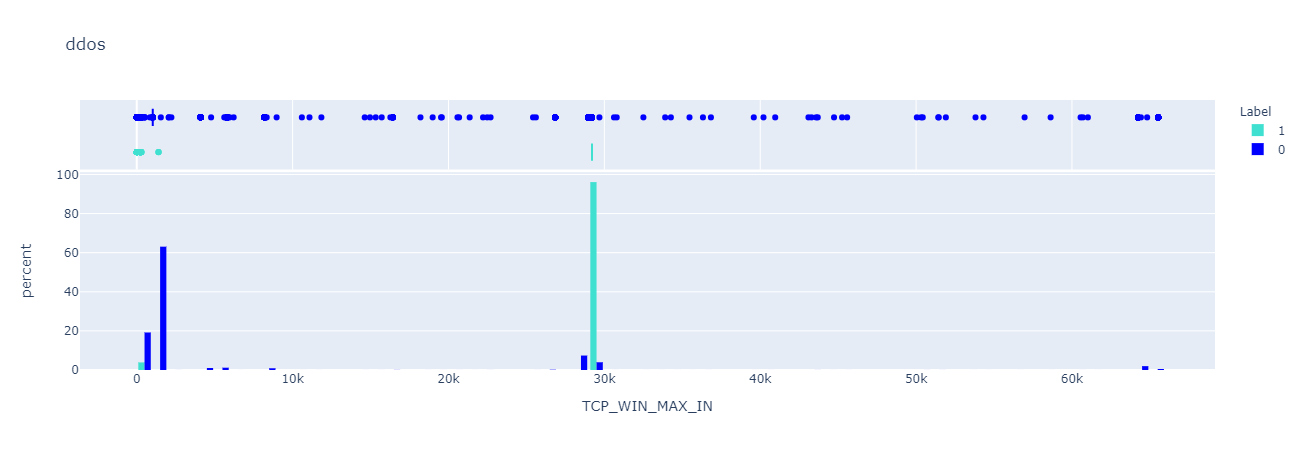

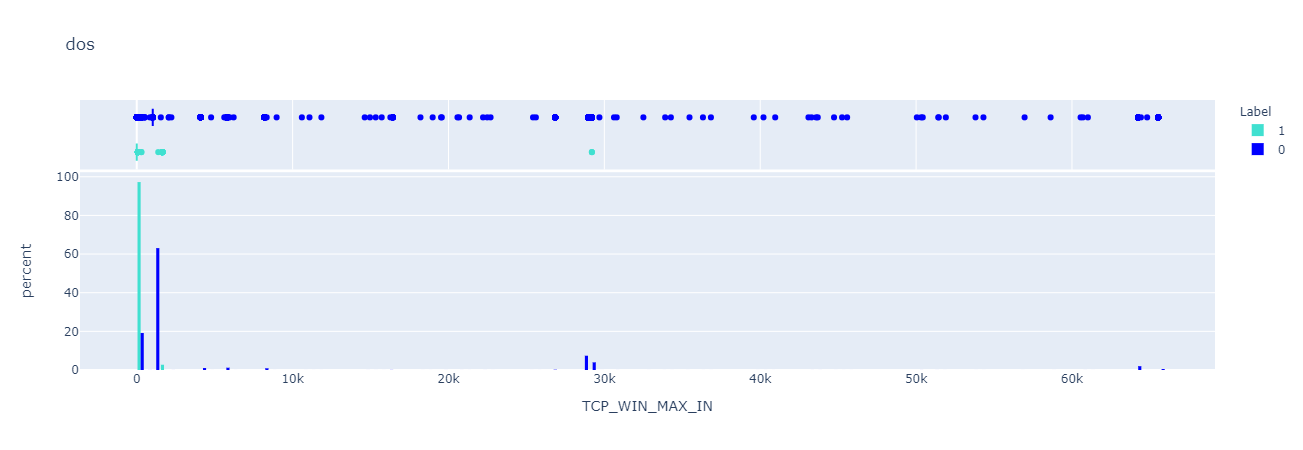

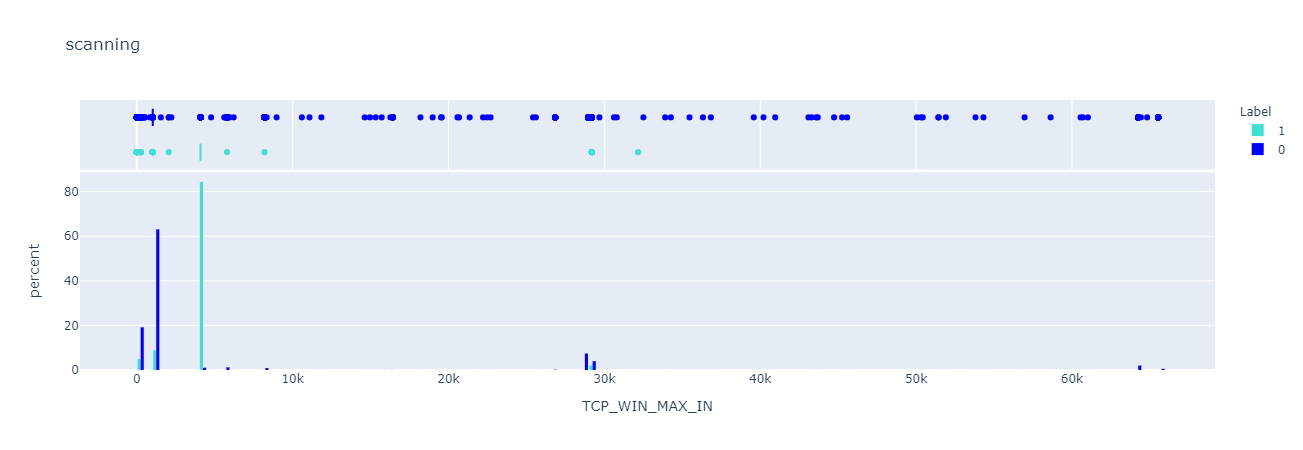

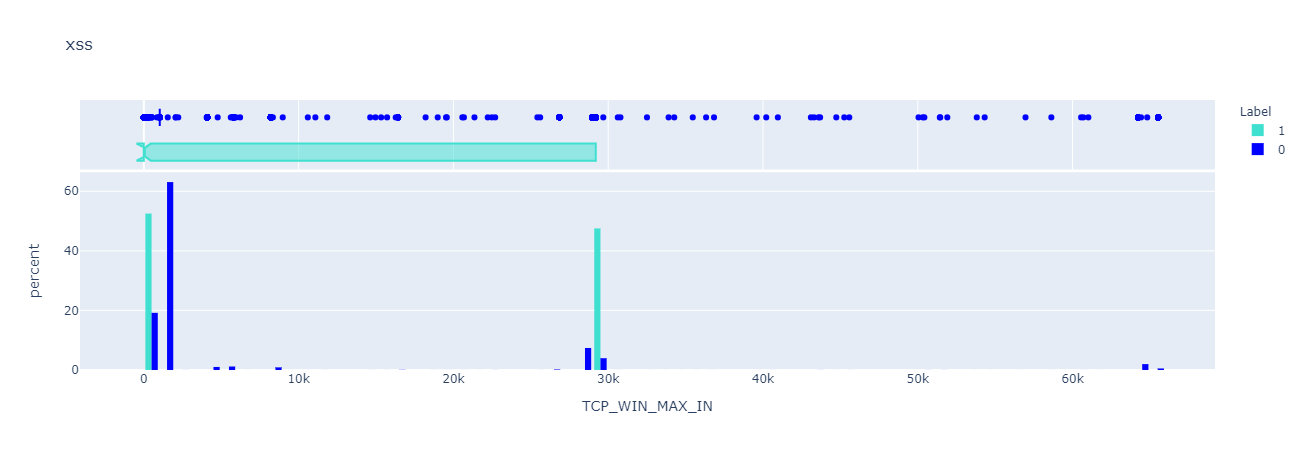

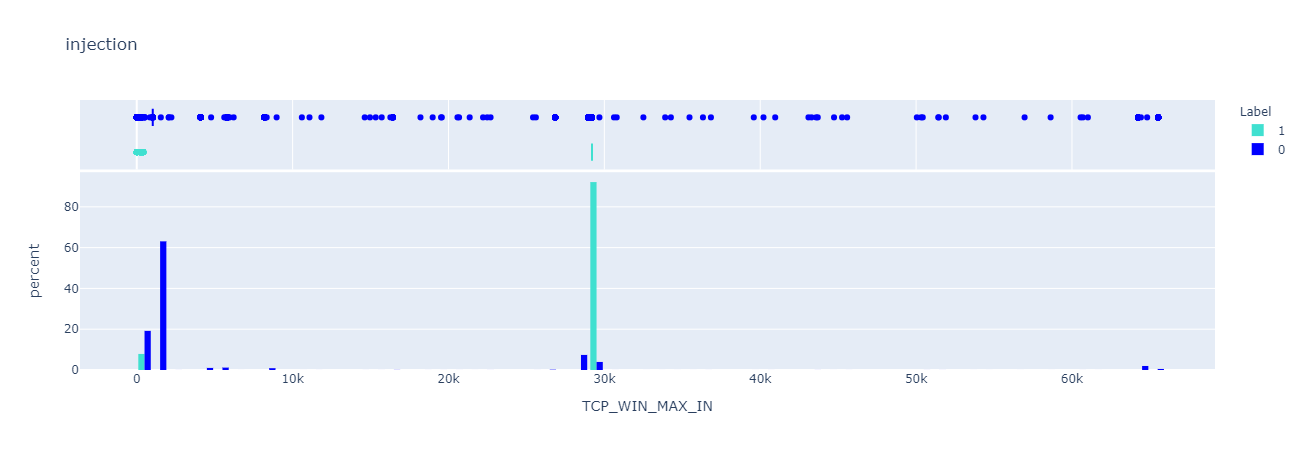

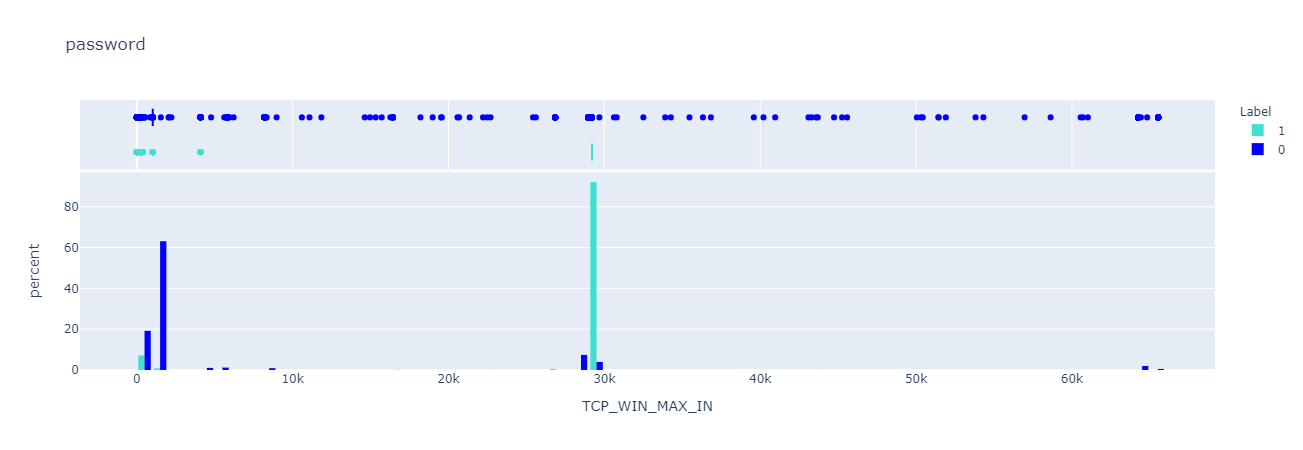

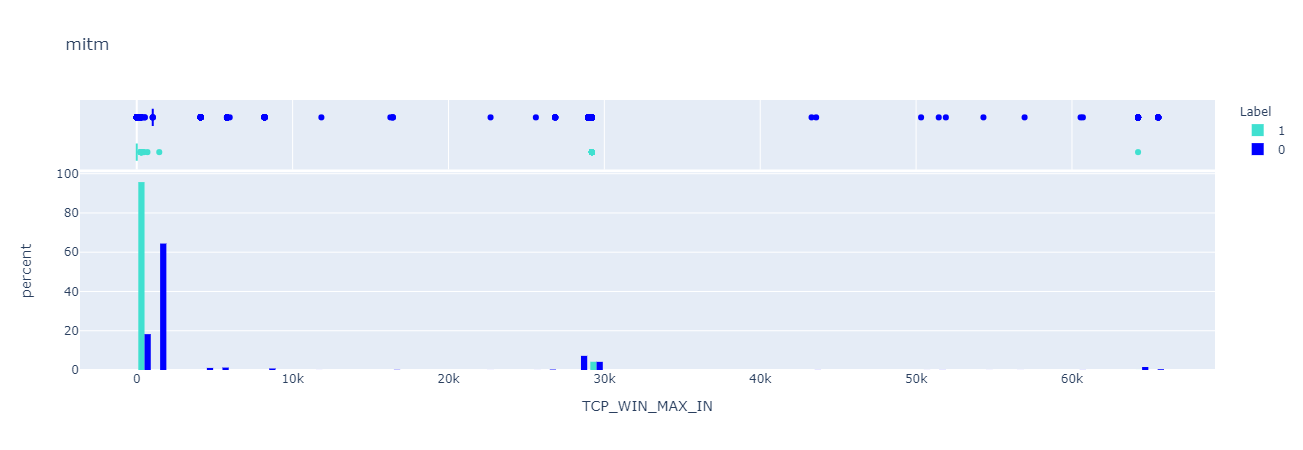

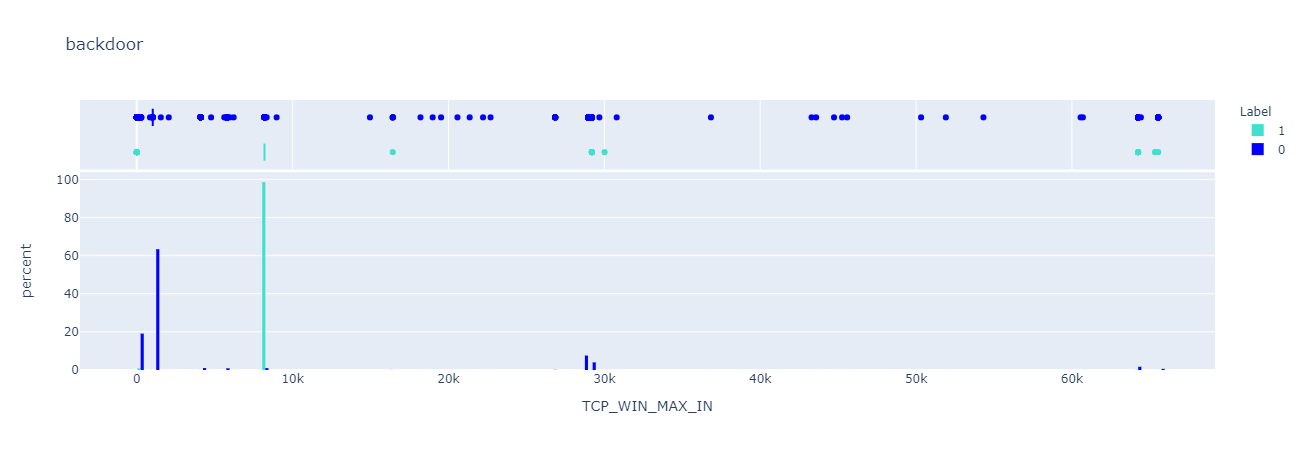

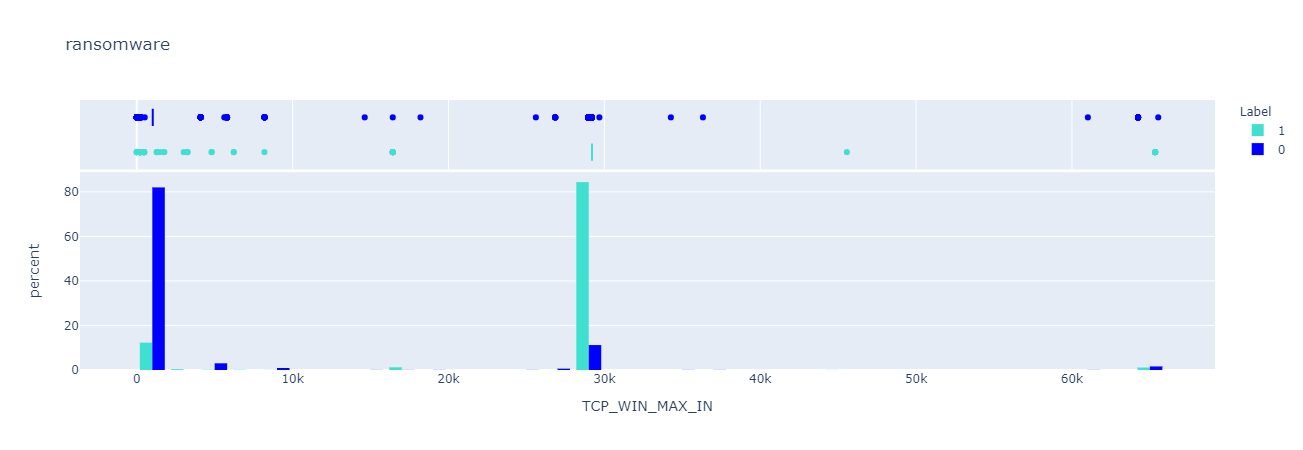

In [22]:
for attack in attacks[1:]:
    fig=px.histogram(
    training_dfs[attack],
    x='TCP_WIN_MAX_IN',
    color='Label',
    marginal='box',
    barmode='group',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [23]:
(training_set.groupby('Attack')['TCP_WIN_MAX_IN'].apply(lambda x: ((x==29200) | (x==4049)| (x==0)| (x==4096)| (x==8192)).mean())*100).reset_index(name='Percentage')

Attack  Percentage
0      Benign   21.203555
1    backdoor   99.690211
2        ddos   98.100467
3         dos   93.167566
4   injection   97.285066
5        mitm   99.025424
6    password   95.310883
7  ransomware   84.900000
8    scanning   91.133264
9         xss   99.227221

### LONGEST_FLOW_PKT

In [ ]:
import math
for attack in attacks[1:]:
    d=training_dfs[attack]#[training_dfs[attack].ICMP_TYPE<=1000000]
    k=d#[training_dfs[attack].Label==1]
#     k=k[k.DST_TO_SRC_AVG_THROUGHPUT>0]
    bin_width= 10000
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["LONGEST_FLOW_PKT"].max() - k["LONGEST_FLOW_PKT"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='LONGEST_FLOW_PKT',
    color='Label',
    marginal='box',
    barmode='group',#nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
(training_set.groupby('Attack')['LONGEST_FLOW_PKT'].apply(lambda x: ((x<60)).mean())*100).reset_index(name='Percentage')

### SRC_TO_DST_AVG_THROUGHPUT

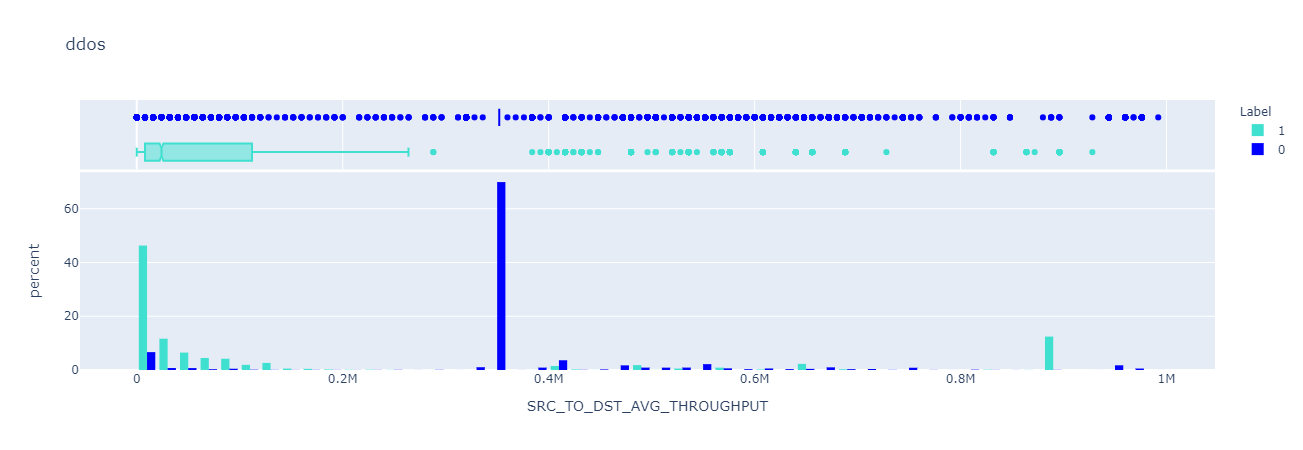

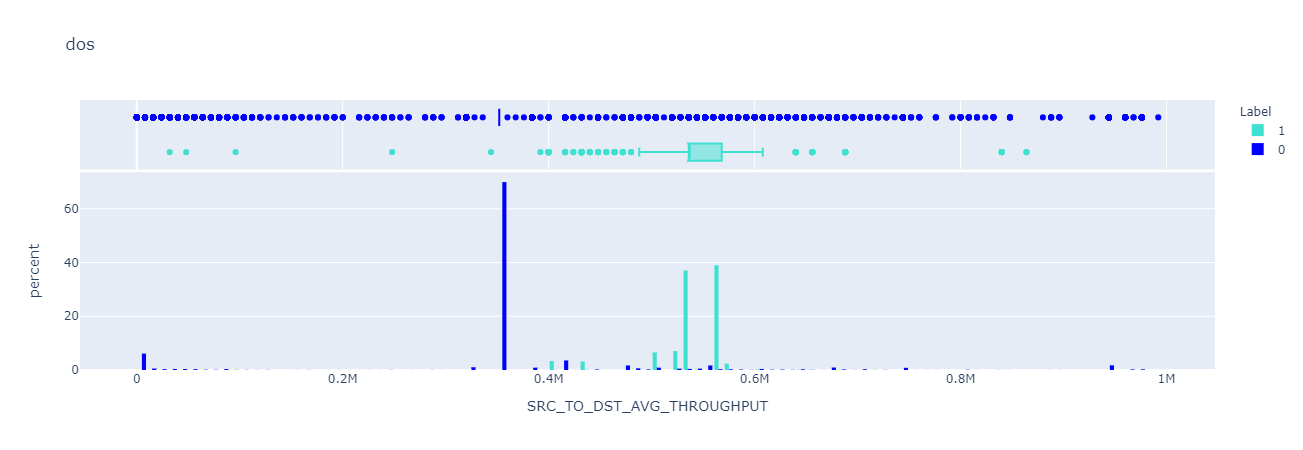

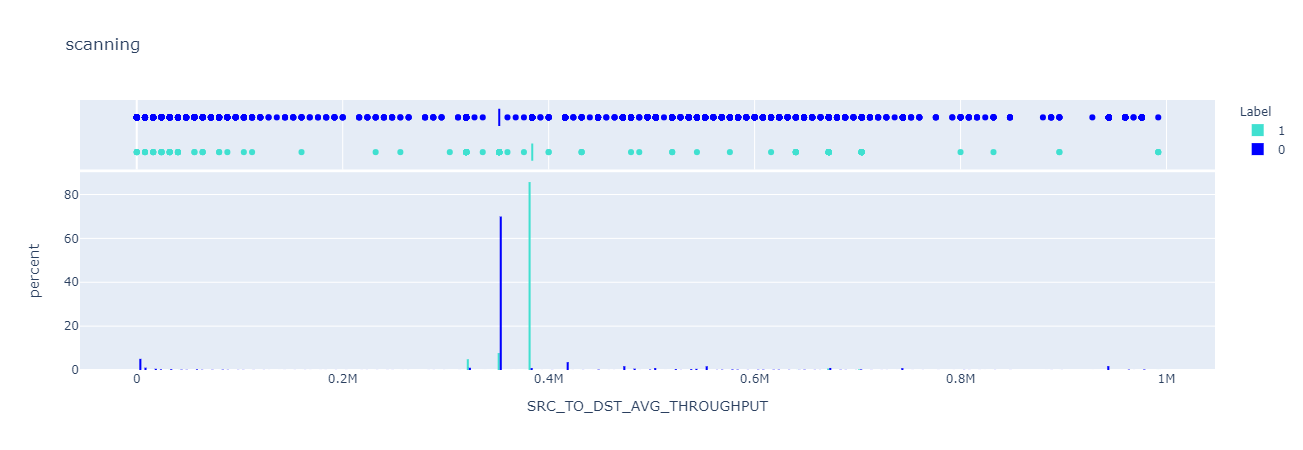

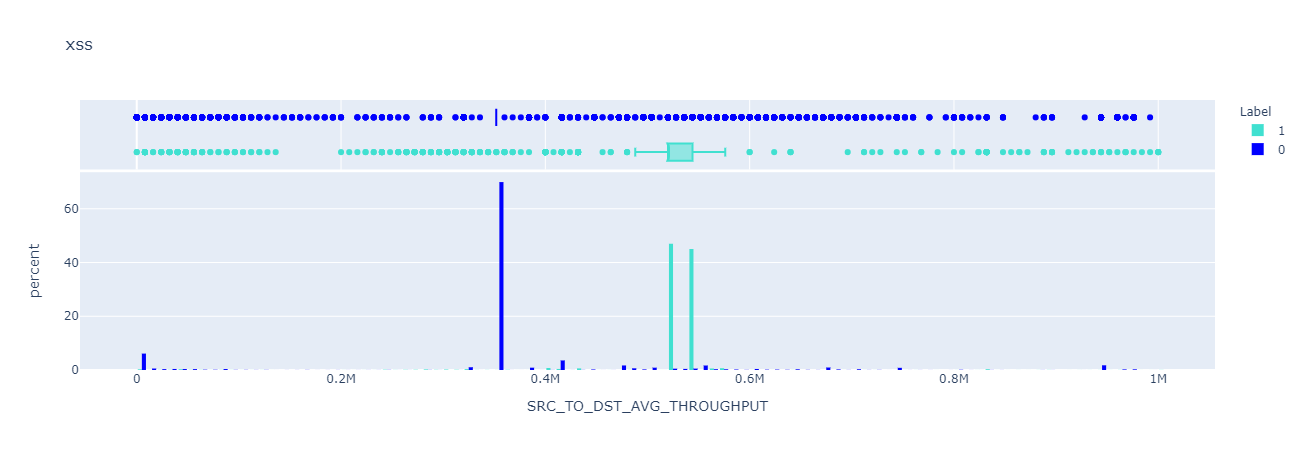

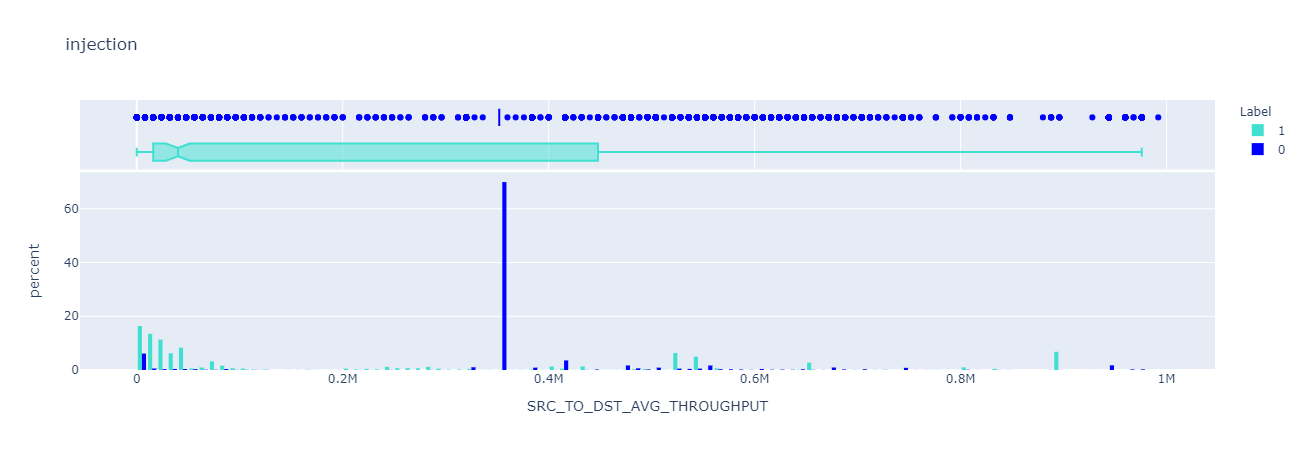

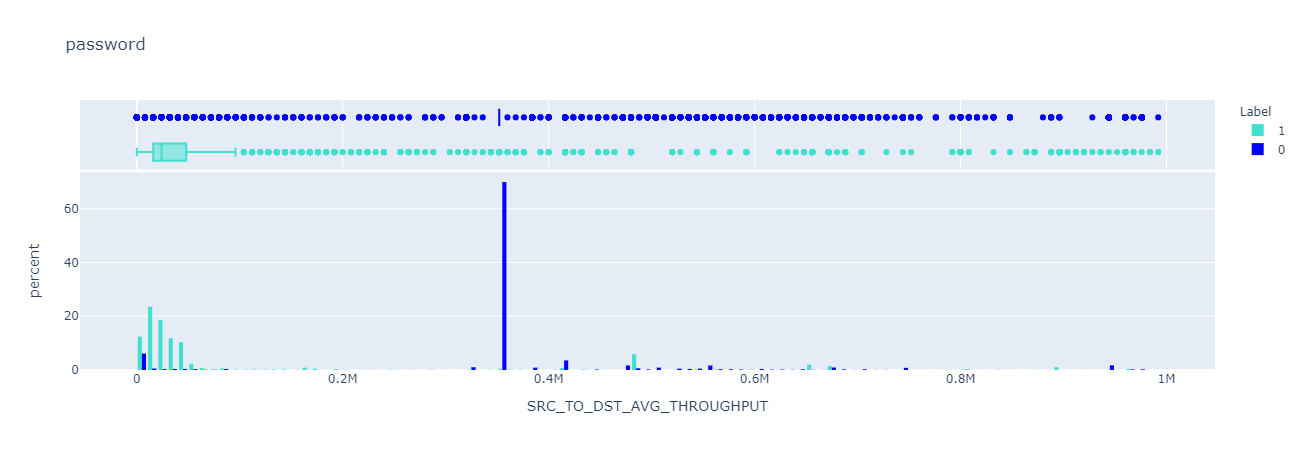

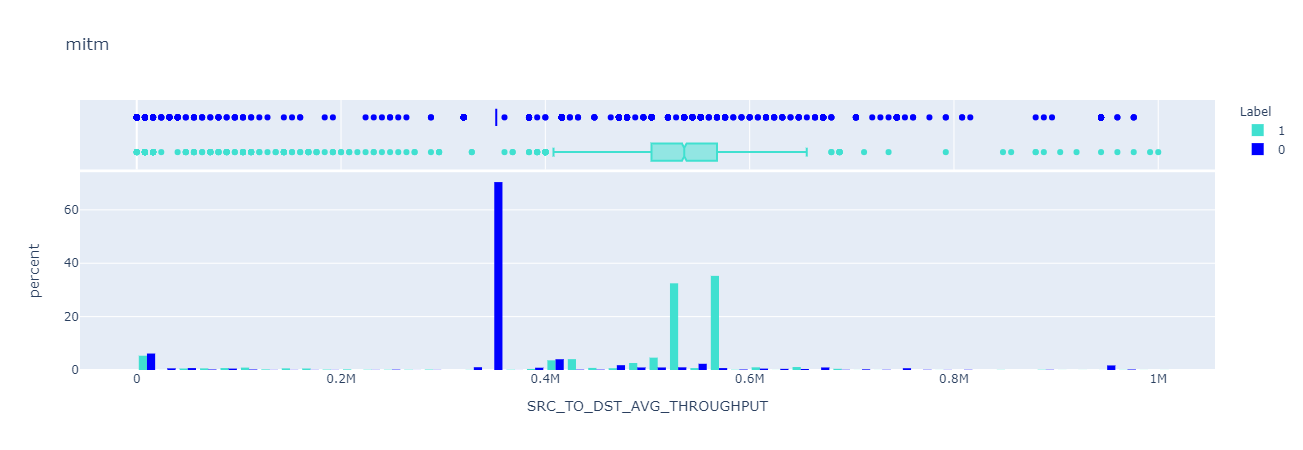

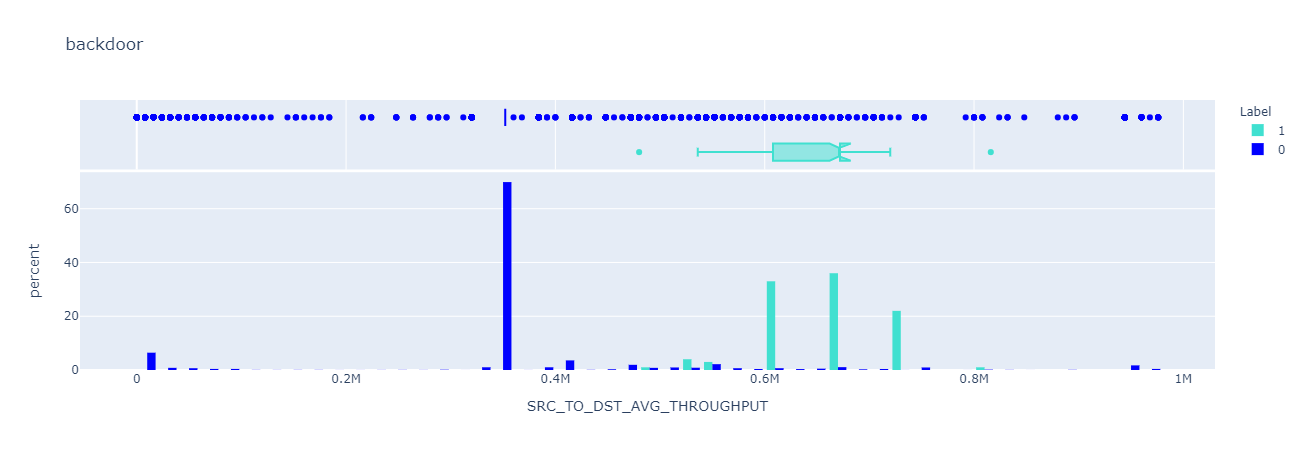

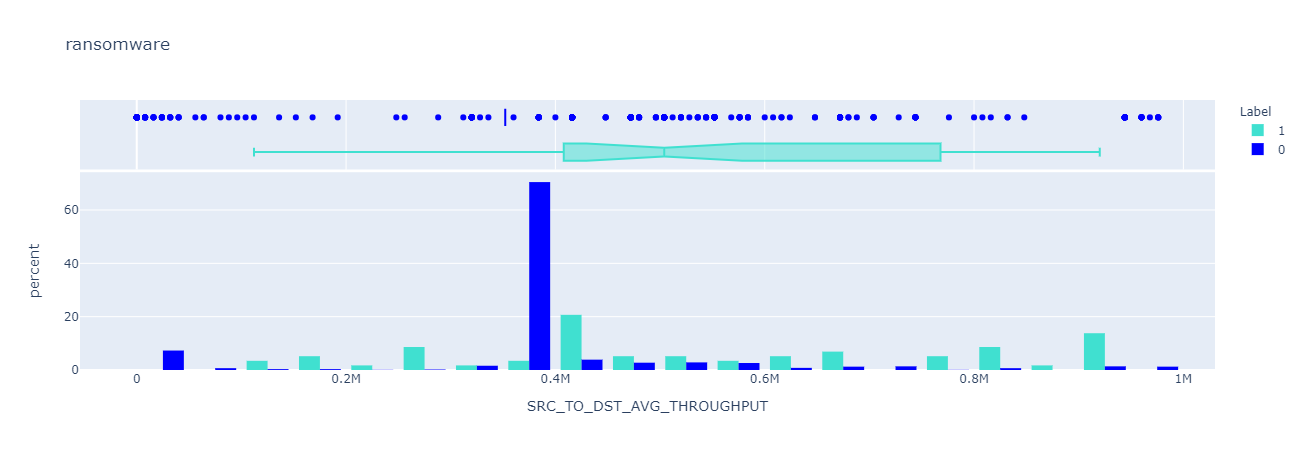

In [31]:
import math
for attack in attacks[1:]:
    d=training_dfs[attack][training_dfs[attack].SRC_TO_DST_AVG_THROUGHPUT<=1000000]
    k=d#[training_dfs[attack].Label==1]
#     k=k[k.DST_TO_SRC_AVG_THROUGHPUT>0]
    bin_width= 10000
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["SRC_TO_DST_AVG_THROUGHPUT"].max() - k["SRC_TO_DST_AVG_THROUGHPUT"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='SRC_TO_DST_AVG_THROUGHPUT',
    color='Label',
    marginal='box',
    barmode='group',#nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [32]:
(training_set.groupby('Attack')['SRC_TO_DST_AVG_THROUGHPUT'].apply(lambda x: ((x>520000)|(x<100000)|(x==384000)).mean())*100).reset_index(name='Percentage')

Attack  Percentage
0      Benign   29.808247
1    backdoor   99.979347
2        ddos   92.089639
3         dos   80.833976
4   injection   92.762359
5        mitm   81.016949
6    password   94.463967
7  ransomware   96.800000
8    scanning   87.393296
9         xss   72.861066

### IN_BYTES

In [ ]:
import math
for attack in attacks[1:]:
    d=training_dfs[attack]#[training_dfs[attack].IN_BYTES<=10000]
    k=d#[training_dfs[attack].Label==1]
#     k=k[k.DST_TO_SRC_AVG_THROUGHPUT>0]
    bin_width= 100
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["IN_BYTES"].max() - k["IN_BYTES"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='IN_BYTES',
    color='Label',
    marginal='box',
    barmode='group',#nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [33]:
training_set.groupby('Attack')['IN_BYTES'].apply(lambda x: ((x>142)|(x.between(61,76)|(x==48))).mean() * 100)

Attack
Benign        23.445690
backdoor      99.979347
ddos          89.856871
dos           92.655147
injection     97.042148
mitm          68.559322
password      88.956488
ransomware    98.600000
scanning      86.070632
xss           98.712989
Name: IN_BYTES, dtype: float64

### min_ttl

In [ ]:
px.histogram(training_set, x="MIN_TTL",color="Label",barmode='group',histnorm='percent')

In [ ]:
training_set.groupby(["Label","MIN_TTL"]).MIN_TTL.count()

In [ ]:
training_set.groupby('Attack')['MIN_TTL'].apply(lambda x : ((x==0)|(x==64)|(x==128)).mean()*100)

In [ ]:
training_dfs["backdoor"].MIN_TTL

In [ ]:
for attack in attacks[1:]:
    fig=px.histogram(
    training_dfs[attack],
    x='MIN_TTL',
    color='Label',
    marginal='box',
    barmode='group',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

### MIN_IP_PKT_LEN

In [ ]:
for attack in attacks[1:]:
    fig=px.histogram(
    training_dfs[attack],
    x='MIN_IP_PKT_LEN',
    color='Label',    barmode='group',

    marginal='box',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
(training_set.groupby('Attack')['MIN_IP_PKT_LEN'].apply(lambda x: ((x>=50)).mean())*100).reset_index(name='Percentage')

### SHORTEST_FLOW_PKT

In [ ]:
for attack in attacks[1:]:
    fig=px.histogram(
    training_dfs[attack],
    x='SHORTEST_FLOW_PKT',
    color='Label',
    marginal='box',
    barmode='group',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
(training_set.groupby('Attack')['SHORTEST_FLOW_PKT'].apply(lambda x: ((x<52)).mean())*100).reset_index(name='Percentage')

### TCP_FLAGS

In [ ]:
for attack in attacks[1:]:
    fig=px.histogram(
    training_dfs[attack],
    x='TCP_FLAGS',
    color='Label',
    marginal='box',
    barmode='group',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
training_set.groupby('Attack')['TCP_FLAGS'].apply(lambda x: ((x ==0)|(x ==27)|(x ==31)|(x ==22)).mean() * 100)

### TCP_WIN_MAX_OUT

In [ ]:
for attack in attacks[1:]:
    fig=px.histogram(
    training_dfs[attack],
    x='TCP_WIN_MAX_OUT',
    color='Label',
    marginal='box',
    barmode='group',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
training_set.groupby('Attack')['TCP_WIN_MAX_OUT'].apply(lambda x: ((x ==0)).mean() * 100)

### TCP_WIN_MAX_IN

In [ ]:
for attack in attacks[1:]:
    fig=px.histogram(
    training_dfs[attack],
    x='TCP_WIN_MAX_IN',
    color='Label',
    marginal='box',
    barmode='group',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

### DST_TO_SRC_SECOND_BYTES

In [ ]:
import math
for attack in attacks[1:]:
    d=training_dfs[attack][training_dfs[attack].DST_TO_SRC_SECOND_BYTES<=1000000]
    k=d#[d.Label==1]
    bin_width= 1000
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["DST_TO_SRC_SECOND_BYTES"].max() - k["DST_TO_SRC_SECOND_BYTES"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='DST_TO_SRC_SECOND_BYTES',
    color='Label',#nbins=nbins,
    marginal='box',
    barmode='group',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [34]:
(training_set.groupby('Attack')['DST_TO_SRC_SECOND_BYTES'].apply(lambda x: ((x>64)).mean())*100).reset_index(name='Percentage')

Attack  Percentage
0      Benign   27.897749
1    backdoor   99.979347
2        ddos   90.344979
3         dos   85.674060
4   injection   96.747320
5        mitm   92.330508
6    password   93.768561
7  ransomware   89.900000
8    scanning    3.463451
9         xss   98.136504

### OUT_BYTES

In [ ]:
import math
for attack in attacks[1:]:
    d=training_dfs[attack][training_dfs[attack].DST_TO_SRC_SECOND_BYTES<=1000000]
    k=d#[d.Label==1]
    bin_width= 100
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["OUT_BYTES"].max() - k["OUT_BYTES"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='OUT_BYTES',
    color='Label',
    marginal='box',
    barmode='group',#nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [35]:
training_set.groupby('Attack')['OUT_BYTES'].apply(lambda x: (x >50).mean() * 100)

Attack
Benign        29.910616
backdoor      99.979347
ddos          97.554115
dos           88.925136
injection     99.158355
mitm          95.127119
password      93.921416
ransomware    95.800000
scanning       3.556659
xss           98.922905
Name: OUT_BYTES, dtype: float64

### DST_TO_SRC_AVG_THROUGHPUT

In [ ]:
import math
for attack in attacks[1:]:
#     d=training_dfs[attack][training_dfs[attack].DST_TO_SRC_SECOND_BYTES<=1000000]
    k=training_dfs[attack]#[training_dfs[attack].Label==1]
    k=k[k.DST_TO_SRC_AVG_THROUGHPUT>0]
    bin_width= 100000
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["DST_TO_SRC_AVG_THROUGHPUT"].max() - k["DST_TO_SRC_AVG_THROUGHPUT"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='DST_TO_SRC_AVG_THROUGHPUT',
    color='Label',
    marginal='box',
    barmode='group',#nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
(training_set.groupby('Attack')['DST_TO_SRC_AVG_THROUGHPUT'].apply(lambda x: ((x>417000)).mean())*100).reset_index(name='Percentage')

### NUM_PKTS_UP_TO_128_BYTES

In [ ]:
import math
for attack in attacks[1:]:
#     d=training_dfs[attack][training_dfs[attack].DST_TO_SRC_SECOND_BYTES<=1000000]
    k=training_dfs[attack][training_dfs[attack].Label==1]
    k=k[k.NUM_PKTS_UP_TO_128_BYTES>0]
    bin_width= 5
#     here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["NUM_PKTS_UP_TO_128_BYTES"].max() - k["NUM_PKTS_UP_TO_128_BYTES"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='NUM_PKTS_UP_TO_128_BYTES',
    color='Label',
    marginal='box',
    barmode='group',nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
training_set.groupby('Attack')['NUM_PKTS_UP_TO_128_BYTES'].apply(lambda x: ((x<=2)).mean() * 100)

### IN_PKTS

In [ ]:
import math
for attack in attacks[1:]:
#     d=training_dfs[attack][training_dfs[attack].DST_TO_SRC_SECOND_BYTES<=1000000]
    k=training_dfs[attack][training_dfs[attack].Label==1]
#     k=k[k.DST_TO_SRC_AVG_THROUGHPUT>0]
    bin_width= 5
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["IN_PKTS"].max() - k["IN_PKTS"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='IN_PKTS',
    color='Label',
    marginal='box',
    barmode='group',nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
training_set.groupby('Attack')['IN_PKTS'].apply(lambda x: ((x==1)).mean() * 100)

### SRC_TO_DST_SECOND_BYTES

In [ ]:
import math
for attack in attacks[1:]:
    d=training_dfs[attack]#[training_dfs[attack].SRC_TO_DST_SECOND_BYTES<=1000000]
    k=d#[training_dfs[attack].Label==1]
    k=k[k.SRC_TO_DST_SECOND_BYTES<=1000000]
    bin_width= 100
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["SRC_TO_DST_SECOND_BYTES"].max() - k["SRC_TO_DST_SECOND_BYTES"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='SRC_TO_DST_SECOND_BYTES',
    color='Label',
    marginal='box',
    barmode='group',#nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [36]:
training_set.groupby('Attack')['SRC_TO_DST_SECOND_BYTES'].apply(lambda x: ((x>150)|(x==48)|(x==67)|(x.between(61,71))).mean() * 100)

Attack
Benign        23.599615
backdoor      99.297811
ddos          89.444386
dos           90.416227
injection     97.035092
mitm          86.567797
password      95.321298
ransomware    98.400000
scanning      86.062309
xss           98.442183
Name: SRC_TO_DST_SECOND_BYTES, dtype: float64

### ICMP_TYPE

In [1]:
import math
for attack in attacks[1:]:
    d=training_dfs[attack]#[training_dfs[attack].ICMP_TYPE<=1000000]
    k=d#[training_dfs[attack].Label==1]
    k=k[k.ICMP_TYPE>0]
    bin_width= 1000
    # here you can choose your rounding method, I've chosen math.ceil
    #nbins = math.ceil((k["ICMP_TYPE"].max() - k["ICMP_TYPE"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='ICMP_TYPE',
    color='Label',
    marginal='box',
    barmode='group',#nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [26]:
(training_set.groupby('Attack')['ICMP_TYPE'].apply(lambda x: ((x==0)|(x==0)).mean())*100).reset_index(name='Percentage')

Attack  Percentage
0      Benign   97.974267
1    backdoor  100.000000
2        ddos   98.670308
3         dos   99.998985
4   injection   97.928647
5        mitm   99.661017
6    password   85.393458
7  ransomware   90.500000
8    scanning   99.992787
9         xss   99.045639

In [27]:
(training_set[training_set.ICMP_TYPE>0].groupby('Attack')['ICMP_TYPE'].apply(lambda x: ((x==35840)|(x==771)).mean())*100).reset_index(name='Percentage')

Attack  Percentage
0      Benign    2.220598
1        ddos    0.028723
2         dos    0.000000
3   injection    0.267640
4        mitm    0.000000
5    password    0.043699
6  ransomware    0.000000
7    scanning    1.538462
8         xss    0.157008

### L7_PROTO

In [ ]:
import math
for attack in attacks[1:]:
    d=training_dfs[attack]#[training_dfs[attack].ICMP_TYPE<=1000000]
    k=d[training_dfs[attack].Label==1]
#     k=k[k.DST_TO_SRC_AVG_THROUGHPUT>0]
    bin_width= 5
    # here you can choose your rounding method, I've chosen math.ceil
    nbins = math.ceil((k["L7_PROTO"].max() - k["L7_PROTO"].min()) / bin_width)
    fig=px.histogram(
    k,
    x='L7_PROTO',
    color='Label',
    marginal='box',
    barmode='group',nbins=nbins,
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
(training_set.groupby('Attack')['L7_PROTO'].apply(lambda x: ((x==7)|(x==41)|(x==7)|(x==131)|(x==91)).mean())*100).reset_index(name='Percentage')

### PROTOCOL

In [ ]:
training_set.groupby('Attack')['PROTOCOL'].apply(lambda x: ((x==6)|(x==17)).mean() * 100)

### CLIENT_TCP_FLAGS

In [ ]:
for attack in attacks[1:]:
    fig=px.histogram(
    training_dfs[attack],
    x='CLIENT_TCP_FLAGS',
    color='Label',
    marginal='box',
    barmode='group',
    color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
    fig.show()

In [ ]:
training_set.groupby('Attack')['CLIENT_TCP_FLAGS'].apply(lambda x: ((x !=2)& (x!=0)).mean() * 100)

### FLOW_DURATION_MILLISECONDS

In [2]:
# for attack in attacks[1:]:
#     fig=px.histogram(
#     training_dfs[attack],
#     x='FLOW_DURATION_MILLISECONDS',
#     color='Label',
#     marginal='box',
#     barmode='group',
#     color_discrete_sequence=['turquoise','blue'],histnorm='percent',title=attack)
#     fig.show()

In [63]:
(training_set.groupby('Attack')['FLOW_DURATION_MILLISECONDS'].apply(lambda x: ((x==0)).mean())*100).reset_index(name='Percentage')

Attack  Percentage
0      Benign   86.613927
1    backdoor   98.244527
2        ddos   24.609142
3         dos   99.100982
4   injection   64.937683
5        mitm   88.983051
6    password   52.691925
7  ransomware   89.800000
8    scanning   92.780936
9         xss   91.159427

In [29]:
(training_set.groupby('Attack')['FTP_COMMAND_RET_CODE'].apply(lambda x: ((x==0)).mean())*100).reset_index(name='Percentage')

Attack  Percentage
0      Benign   99.932247
1    backdoor  100.000000
2        ddos  100.000000
3         dos  100.000000
4   injection  100.000000
5        mitm  100.000000
6    password   94.545937
7  ransomware  100.000000
8    scanning   99.989792
9         xss  100.000000